# 1. Creating prompt for classfication task with augmented features

In [425]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [ ]:
pd.set_option('display.max_columns', None)

In [436]:
pd.reset_option('display.max_columns')

In [440]:
df_data_turbidity = pd.read_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/cage_SAD_llm/data/new_1_turbidity_data.csv')

### TriQ needs to be removed as it cannot be feature augmented

In [441]:
turbidity_wo_triq = df_data_turbidity[df_data_turbidity['tri_name'] != 'TriQ']


In [442]:
print(df_data_turbidity.shape, turbidity_wo_triq.shape)

(366, 42) (348, 42)


### Now let's filter some columns

In [443]:
def load_and_filter_csv(df):
    
    required_columns = [
    'di_name', 'tri_name', 'di_smiles', 'tri_smiles', 'turbidity_label',
    'turbidity', 'turbidity_binary','di_charge', 'di_complexity',
    'di_covalent_unit_count', 'di_defined_atom_stereo_count',
    'di_defined_bond_stereo_count', 'di_exact_mass',
    'di_h_bond_acceptor_count', 'di_h_bond_donor_count',
    'di_heavy_atom_count', 'di_xlogp', 'di_molecular_weight',
    'di_rotatable_bond_count', 'di_tpsa',
    'tri_charge', 'tri_complexity',
    'tri_covalent_unit_count', 'tri_defined_atom_stereo_count',
    'tri_defined_bond_stereo_count', 'tri_exact_mass',
    'tri_h_bond_acceptor_count', 'tri_h_bond_donor_count',
    'tri_heavy_atom_count', 'tri_xlogp', 'tri_molecular_weight',
    'tri_rotatable_bond_count', 'tri_tpsa',
    'di_arom_group', 'tri_arom_group'
    
    ]
    
    available_columns = [col for col in required_columns if col in df.columns]
    
    if not available_columns:
        print("None of the required columns are available in the Excel file.")
        return None

    
    filtered_df = df[available_columns]

    filtered_df.fillna('unknown', inplace=True)

    return filtered_df


In [444]:
turbidity_wo_triq_clean = load_and_filter_csv(turbidity_wo_triq)

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_4912/2768437202.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.fillna('unknown', inplace=True)


In [445]:
duplicates = turbidity_wo_triq_clean[turbidity_wo_triq_clean.duplicated(subset=['di_smiles', 'tri_smiles'])]
duplicates

,di_name,tri_name,di_smiles,tri_smiles,turbidity_label,turbidity,turbidity_binary,di_charge,di_complexity,di_covalent_unit_count,...,tri_exact_mass,tri_h_bond_acceptor_count,tri_h_bond_donor_count,tri_heavy_atom_count,tri_xlogp,tri_molecular_weight,tri_rotatable_bond_count,tri_tpsa,di_arom_group,tri_arom_group


### Now let's prepare the prompts for testing LLMs

In [450]:
prompts_all = [
    f"Would the mixture involving the ditopic {row['di_smiles']} and tritopic {row['tri_smiles']} building blocks be turbid or dissolved ? Knowing the following propreties about them: "
    
    f"The overall charge of the ditopic specie is {row['di_charge']} and of the tritopic specie is {row['tri_charge']}. "
    f"The complexity index of the ditopic specie is {row['di_complexity']} and of the tritopic specie is {row['tri_complexity']}. "
    f"The covalent unit count of the ditopic specie is {row['di_covalent_unit_count']} and of the tritopic specie is {row['tri_covalent_unit_count']}. "
    f"The number of stereocentric atoms of the ditopic specie is {row['di_defined_atom_stereo_count']} and of the tritopic specie is {row['tri_defined_atom_stereo_count']}. "
    f"The number of stereocentric bonds of the ditopic specie is {row['di_defined_bond_stereo_count']} and of the tritopic specie is {row['tri_defined_bond_stereo_count']}. "
    f"The number of rotatable bonds the ditopic specie is {row['di_rotatable_bond_count']} and of the tritopic specie is {row['tri_rotatable_bond_count']}. "

    f"The exact mass of the ditopic specie is {row['di_exact_mass']} and of the tritopic specie is {row['tri_exact_mass']}. "
    f"The molecular weight of the ditopic specie is {row['di_molecular_weight']} and of the tritopic specie is {row['tri_molecular_weight']}. "
    f"The number of aromatic groups in the ditopic specie is {row['di_arom_group']} and of the tritopic specie is {row['tri_arom_group']}. "
   

    f"The number of hydrogen bond acceptors in the ditopic specie is  {row['di_h_bond_acceptor_count']} and of the tritopic specie is {row['tri_h_bond_acceptor_count']}. "
    f"The number of hydrogen bond donnor in the ditopic specie is {row['di_h_bond_donor_count']} and of the tritopic specie is {row['tri_h_bond_donor_count']}. "
    f"The number of heavy atoms in the ditopic specie is {row['di_heavy_atom_count']} and of the tritopic specie is {row['tri_heavy_atom_count']}. "
    f"The logP (octanol/water partition coefficient) of the ditopic specie is {row['di_xlogp']} and of the tritopic specie is {row['tri_xlogp']}. "
    f"The TPSA (topological polar surface area) of the ditopic specie is {row['di_tpsa']} and of the tritopic specie is {row['tri_tpsa']}. "

    for index, row in turbidity_wo_triq_clean.iterrows()
]


In [452]:
prompts_reduced = [
    f"Would the mixture involving the ditopic {row['di_smiles']} and tritopic {row['tri_smiles']} building blocks be turbid or dissolved ? Knowing the following propreties about them: "
    
    f"The number of aromatic groups in the ditopic specie is {row['di_arom_group']} and of the tritopic specie is {row['tri_arom_group']}. "
   
    f"The number of hydrogen bond acceptors in the ditopic specie is  {row['di_h_bond_acceptor_count']} and of the tritopic specie is {row['tri_h_bond_acceptor_count']}. "
    f"The number of hydrogen bond donnor in the ditopic specie is {row['di_h_bond_donor_count']} and of the tritopic specie is {row['tri_h_bond_donor_count']}. "
    f"The number of heavy atoms in the ditopic specie is {row['di_heavy_atom_count']} and of the tritopic specie is {row['tri_heavy_atom_count']}. "
    f"The logP (octanol/water partition coefficient) of the ditopic specie is {row['di_xlogp']} and of the tritopic specie is {row['tri_xlogp']}. "
    f"The TPSA (topological polar surface area) of the ditopic specie is {row['di_tpsa']} and of the tritopic specie is {row['tri_tpsa']}. "

    for index, row in turbidity_wo_triq_clean.iterrows()
]


In [480]:
turbidity_wo_triq_clean = turbidity_wo_triq_clean.reset_index(drop=True)

In [485]:
prompts_df_all = pd.DataFrame(prompts_all, columns=["Prompts"])
prompts_df_all['turbidity'] = turbidity_wo_triq_clean['turbidity_binary']

In [486]:
prompts_df_reduced = pd.DataFrame(prompts_reduced, columns=["Prompts"])
prompts_df_reduced['turbidity'] = turbidity_wo_triq_clean['turbidity_binary']

In [487]:
print(prompts_df_all.shape, prompts_df_reduced.shape)

(348, 2) (348, 2)


## Selecting random 50 test questions

In [457]:
from sklearn.model_selection import train_test_split

### For all features prompt

In [490]:
all_train, all_test = train_test_split(
    prompts_df_all, 
    test_size=50,  
    random_state=42, 
    stratify=prompts_df_all['turbidity']
    
)


### For reduced features prompt

In [489]:
reduced_train, reduced_test = train_test_split(
    prompts_df_reduced, 
    test_size=50,  
    random_state=42, 
    stratify=prompts_df_reduced['turbidity']
    
)


### For features only 

In [460]:
features_df_train, df_test_features = train_test_split(
    df_data_turbidity, 
    test_size=50,  
    random_state=42, 
    stratify=df_data_turbidity['turbidity_label']
)

In [494]:
print(all_train.shape, all_test.shape, reduced_train.shape, reduced_test.shape)

(298, 2) (50, 2) (298, 2) (50, 2)


In [601]:
prompts_df_reduced.to_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/cage_SAD_llm/data/reduced_prompt_data.csv')
prompts_df_all.to_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/cage_SAD_llm/data/all_prompt_data.csv')

### Plotting the turbidity label data distribution

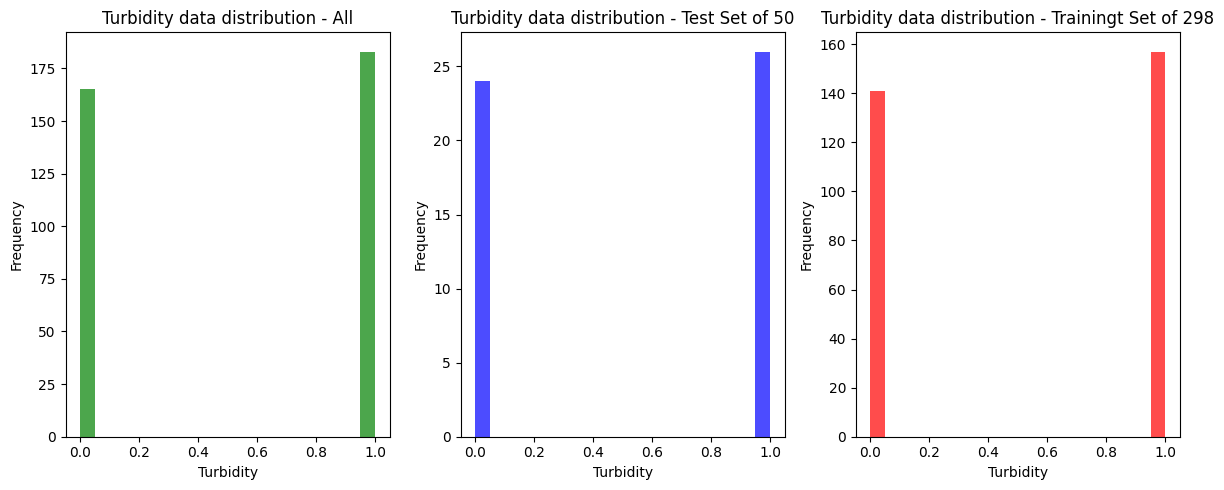

In [495]:
turbidity_prompts_label = prompts_df_reduced['turbidity']
reduced_train_label = reduced_train['turbidity']
reduced_test_label = reduced_test['turbidity']

fig, axs = plt.subplots(1, 3, figsize=(12, 5))

axs[0].hist(turbidity_prompts_label, bins=20, color='green', alpha=0.7)
axs[0].set_title('Turbidity data distribution - All')
axs[0].set_xlabel('Turbidity')
axs[0].set_ylabel('Frequency')

axs[1].hist(reduced_test_label, bins=20, color='blue', alpha=0.7)
axs[1].set_title('Turbidity data distribution - Test Set of 50')
axs[1].set_xlabel('Turbidity')
axs[1].set_ylabel('Frequency')

axs[2].hist(reduced_train_label, bins=20, color='red', alpha=0.7)
axs[2].set_title('Turbidity data distribution - Trainingt Set of 298')
axs[2].set_xlabel('Turbidity')
axs[2].set_ylabel('Frequency')


plt.tight_layout()
plt.show()

In [ ]:
# df_test.to_csv('/Users/davidsegura/desktop/promt_exp_turbidity_gpt_01.csv')

# -----------------------------------------*JUMP*------------------------------------------------------

### Few-shot examples

In [302]:
from sklearn.cluster import KMeans

In [303]:
features_df_train = load_and_filter_csv(features_df_train)

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_4912/2420764611.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.fillna('unknown', inplace=True)


In [304]:
features_df_train

,di_name,tri_name,turbidity_label,di_smiles,tri_smiles,di_cactvs_fingerprint,di_fingerprint,di_charge,di_complexity,di_covalent_unit_count,...,tri_h_bond_donor_count,tri_heavy_atom_count,tri_xlogp,tri_molecular_weight,tri_rotatable_bond_count,tri_tpsa,di_hardness,di_nbr_arom,tri_hardness,tri_nbr_arom
187,Di25,TriJ,dissolved,NCCCCCCNCCCCCCN,O=Cc1ccc(N(c2ccc(C=O)cc2)c2ccc(C=O)cc2)cc1,1110000001110011000000000000000000000000000000...,00000371E0730000000000000000000000000000000000...,0.0,95.0,1.0,...,0.0,25.0,3.5,329.30,6.0,54.4,Flexible,0,Rigid,3
205,Di28,TriJ,turbid,NCC1CCC(CN)CC1,O=Cc1ccc(N(c2ccc(C=O)cc2)c2ccc(C=O)cc2)cc1,1110000001110011000000000000000000000000000000...,00000371E0730000000000000000000000000000000000...,0.0,73.3,1.0,...,0.0,25.0,3.5,329.30,6.0,54.4,Flexible,0,Rigid,3
59,Di18,TriL,turbid,CC(C)(CN)CN,O=Cc1ccc(C#Cc2cc(C#Cc3ccc(C=O)cc3)cc(C#Cc3ccc(...,1100000001100011000000000000000000000000000000...,00000371C0630000000000000000000000000000000000...,0.0,44.0,1.0,...,0.0,36.0,6.4,462.50,9.0,51.2,Flexible,0,Rigid,4
57,Di18,TriJ,turbid,CC(C)(CN)CN,O=Cc1ccc(N(c2ccc(C=O)cc2)c2ccc(C=O)cc2)cc1,1100000001100011000000000000000000000000000000...,00000371C0630000000000000000000000000000000000...,0.0,44.0,1.0,...,0.0,25.0,3.5,329.30,6.0,54.4,Flexible,0,Rigid,3
332,Di33,TriI,dissolved,NCCCC[C@H](N)C(=O)O,O=Cc1cc(C=O)c(O)c(C=O)c1,1100000001100011001100000000000000000000000000...,00000371C0633000000000000000000000000000000000...,0.0,106.0,1.0,...,1.0,13.0,0.5,178.14,3.0,71.4,Flexible,0,Rigid,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,Di18,TriO,dissolved,CC(C)(CN)CN,O=Cc1cc(-c2cc(-c3csc(C=O)c3)cc(-c3csc(C=O)c3)c...,1100000001100011000000000000000000000000000000...,00000371C0630000000000000000000000000000000000...,0.0,44.0,1.0,...,0.0,27.0,5.2,408.50,6.0,136.0,Flexible,0,Rigid,4
51,Di17,TriJ,turbid,NCCN,O=Cc1ccc(N(c2ccc(C=O)cc2)c2ccc(C=O)cc2)cc1,1100000001000011000000000000000000000000000000...,00000371C0430000000000000000000000000000000000...,0.0,6.0,1.0,...,0.0,25.0,3.5,329.30,6.0,54.4,Flexible,0,Rigid,3
27,Di5,TriD,turbid,O=Cc1c(F)c(F)c(C=O)c(F)c1F,CCc1c(CN)c(CC)c(CN)c(CC)c1CN,0000000001110000001100011100000000000000000000...,00000371007031C0000000000000000000000000000000...,0.0,195.0,1.0,...,3.0,18.0,0.9,249.39,6.0,78.1,Rigid,1,Flexible,1
228,Di31,TriR,turbid,NCC1=CC(CN)=CC=C1,O=Cc1ccc(OCc2cc(COc3ccc(C=O)cc3)cc(COc3ccc(C=O...,1100000001110011000000000000000000000000000000...,00000371C0730000000000000000000000000000000000...,0.0,83.3,1.0,...,0.0,36.0,4.7,480.50,12.0,78.9,Flexible,1,Flexible,4


In [305]:
features_df_train.drop(['di_name', 'tri_name', 'di_smiles', 'tri_smiles','di_cactvs_fingerprint', 'di_fingerprint', 'tri_fingerprint', 'tri_cactvs_fingerprint', 'di_hardness', 'tri_hardness', 'turbidity_label'], axis=1, inplace=True)

In [306]:
df_for_kmeans = features_df_train

In [311]:
X = df_for_kmeans

kmeans = KMeans(n_clusters=10, random_state=42)
df_for_kmeans['cluster'] = kmeans.fit_predict(X)

# Get the representative example for each cluster
representative_examples = df_for_kmeans.groupby('cluster').apply(lambda df: df.iloc[0])


/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_4912/500457805.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  representative_examples = df_for_kmeans.groupby('cluster').apply(lambda df: df.iloc[0])


In [308]:
representative_examples

,di_charge,di_complexity,di_covalent_unit_count,di_defined_atom_stereo_count,di_defined_bond_stereo_count,di_exact_mass,di_h_bond_acceptor_count,di_h_bond_donor_count,di_heavy_atom_count,di_xlogp,...,tri_h_bond_acceptor_count,tri_h_bond_donor_count,tri_heavy_atom_count,tri_xlogp,tri_molecular_weight,tri_rotatable_bond_count,tri_tpsa,di_nbr_arom,tri_nbr_arom,cluster
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.0,44.0,1.0,0.0,0.0,102.115698,2.0,2.0,7.0,-0.5,...,3.0,0.0,36.0,6.4,462.50,9.0,51.2,0.0,4.0,0.0
1,0.0,106.0,1.0,1.0,0.0,146.105528,4.0,3.0,10.0,-3.0,...,4.0,1.0,13.0,0.5,178.14,3.0,71.4,0.0,1.0,1.0
2,0.0,95.0,1.0,0.0,0.0,215.236148,3.0,3.0,15.0,0.8,...,4.0,0.0,25.0,3.5,329.30,6.0,54.4,0.0,3.0,2.0
3,0.0,262.0,1.0,0.0,0.0,214.074228,3.0,0.0,16.0,1.2,...,3.0,3.0,9.0,-1.6,129.20,0.0,78.1,2.0,0.0,3.0
4,0.0,62.9,1.0,2.0,0.0,114.115698,2.0,2.0,8.0,-0.3,...,6.0,0.0,30.0,3.3,393.40,6.0,89.9,0.0,4.0,4.0
5,0.0,73.3,1.0,0.0,0.0,142.146999,2.0,2.0,10.0,0.1,...,4.0,0.0,25.0,3.5,329.30,6.0,54.4,0.0,3.0,5.0
6,0.0,171.0,1.0,2.0,0.0,212.131349,2.0,2.0,16.0,1.4,...,4.0,1.0,13.0,0.5,178.14,3.0,71.4,2.0,1.0,6.0
7,0.0,352.0,1.0,0.0,0.0,330.110338,6.0,0.0,24.0,2.4,...,3.0,3.0,18.0,0.9,249.39,6.0,78.1,2.0,1.0,7.0
8,0.0,171.0,1.0,2.0,0.0,212.131349,2.0,2.0,16.0,1.4,...,3.0,0.0,36.0,7.1,468.50,9.0,51.2,2.0,4.0,8.0


In [309]:
df_for_kmeans

,di_charge,di_complexity,di_covalent_unit_count,di_defined_atom_stereo_count,di_defined_bond_stereo_count,di_exact_mass,di_h_bond_acceptor_count,di_h_bond_donor_count,di_heavy_atom_count,di_xlogp,...,tri_h_bond_acceptor_count,tri_h_bond_donor_count,tri_heavy_atom_count,tri_xlogp,tri_molecular_weight,tri_rotatable_bond_count,tri_tpsa,di_nbr_arom,tri_nbr_arom,cluster
187,0.0,95.0,1.0,0.0,0.0,215.236148,3.0,3.0,15.0,0.8,...,4.0,0.0,25.0,3.5,329.30,6.0,54.4,0,3,2
205,0.0,73.3,1.0,0.0,0.0,142.146999,2.0,2.0,10.0,0.1,...,4.0,0.0,25.0,3.5,329.30,6.0,54.4,0,3,5
59,0.0,44.0,1.0,0.0,0.0,102.115698,2.0,2.0,7.0,-0.5,...,3.0,0.0,36.0,6.4,462.50,9.0,51.2,0,4,0
57,0.0,44.0,1.0,0.0,0.0,102.115698,2.0,2.0,7.0,-0.5,...,4.0,0.0,25.0,3.5,329.30,6.0,54.4,0,3,5
332,0.0,106.0,1.0,1.0,0.0,146.105528,4.0,3.0,10.0,-3.0,...,4.0,1.0,13.0,0.5,178.14,3.0,71.4,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,0.0,44.0,1.0,0.0,0.0,102.115698,2.0,2.0,7.0,-0.5,...,6.0,0.0,27.0,5.2,408.50,6.0,136.0,0,4,4
51,0.0,6.0,1.0,0.0,0.0,60.068748,2.0,2.0,4.0,-2.0,...,4.0,0.0,25.0,3.5,329.30,6.0,54.4,0,3,5
27,0.0,195.0,1.0,0.0,0.0,205.999092,6.0,0.0,14.0,1.2,...,3.0,3.0,18.0,0.9,249.39,6.0,78.1,1,1,6
228,0.0,83.3,1.0,0.0,0.0,136.100048,2.0,2.0,10.0,-0.3,...,6.0,0.0,36.0,4.7,480.50,12.0,78.9,1,4,9


In [310]:
for i, rep_row in representative_examples.iterrows():
    matches = df_for_kmeans.apply(lambda x: all(x[col] == rep_row[col] for col in representative_examples.columns), axis=1)
    matched_indices = df_for_kmeans[matches].index.tolist()
    
    if matched_indices:
        print(f"Match found for row {i} in representative_examples at index(es): {matched_indices}")
    else:
        print(f"No exact match for row {i}. Closest values:")

        similar_rows = df_for_kmeans[(df_for_kmeans['di_complexity'] - rep_row['di_complexity']).abs() < 1e-6]  # Small tolerance for comparison
        print(similar_rows)



Match found for row 0 in representative_examples at index(es): [59]
Match found for row 1 in representative_examples at index(es): [332, 236]
Match found for row 2 in representative_examples at index(es): [187]
Match found for row 3 in representative_examples at index(es): [113]
Match found for row 4 in representative_examples at index(es): [94]
Match found for row 5 in representative_examples at index(es): [205, 301]
Match found for row 6 in representative_examples at index(es): [68]
Match found for row 7 in representative_examples at index(es): [123]
Match found for row 8 in representative_examples at index(es): [252]
Match found for row 9 in representative_examples at index(es): [221, 220, 316, 317]


In [55]:
matching_indices = [59, 332, 187, 252, 68, 205]

In [56]:
features_df_train, df_test_features = train_test_split(
    df_data_turbidity, 
    test_size=50,  
    random_state=42, 
    stratify=df_data_turbidity['turbidity_label']
)

In [57]:
features_df_train_fewshot = features_df_train.loc[matching_indices]

In [58]:
features_df_train_fewshot

,Unnamed: 0,id,reaction_id,experiment_number,di_name,tri_name,turbidity_label,di_smiles,tri_smiles,di_cactvs_fingerprint,...,tri_heavy_atom_count,tri_xlogp,tri_molecular_weight,tri_rotatable_bond_count,tri_tpsa,conversion_label,di_hardness,di_nbr_arom,tri_hardness,tri_nbr_arom
59,59,60,102,AB-02-005,Di18,TriL,turbid,CC(C)(CN)CN,O=Cc1ccc(C#Cc2cc(C#Cc3ccc(C=O)cc3)cc(C#Cc3ccc(...,1100000001100011000000000000000000000000000000...,...,36.0,6.4,462.50,9.0,51.2,complete,Flexible,0,Rigid,4
332,332,375,414,AB-02-007,Di33,TriI,dissolved,NCCCC[C@H](N)C(=O)O,O=Cc1cc(C=O)c(O)c(C=O)c1,1100000001100011001100000000000000000000000000...,...,13.0,0.5,178.14,3.0,71.4,partial,Flexible,0,Rigid,1
187,187,232,363,AB-02-007,Di25,TriJ,dissolved,NCCCCCCNCCCCCCN,O=Cc1ccc(N(c2ccc(C=O)cc2)c2ccc(C=O)cc2)cc1,1110000001110011000000000000000000000000000000...,...,25.0,3.5,329.30,6.0,54.4,partial,Flexible,0,Rigid,3
252,252,297,239,AB-02-007,Di20,TriU,dissolved,N[C@H]([C@H](C1=CC=CC=C1)N)C2=CC=CC=C2,C1=CC(=CC=C1/C=C/C2=CC(=CC(=C2)/C=C/C3=CC=C(C=...,1110000001110011000000000000000000000000000000...,...,36.0,7.1,468.50,9.0,51.2,complete,Flexible,2,Rigid,4
68,68,69,126,AB-02-005,Di20,TriI,turbid,N[C@H]([C@H](C1=CC=CC=C1)N)C2=CC=CC=C2,O=Cc1cc(C=O)c(O)c(C=O)c1,1110000001110011000000000000000000000000000000...,...,13.0,0.5,178.14,3.0,71.4,partial,Flexible,2,Rigid,1
205,205,250,306,AB-02-007,Di28,TriJ,turbid,NCC1CCC(CN)CC1,O=Cc1ccc(N(c2ccc(C=O)cc2)c2ccc(C=O)cc2)cc1,1110000001110011000000000000000000000000000000...,...,25.0,3.5,329.30,6.0,54.4,partial,Flexible,0,Rigid,3


In [59]:
features_df_train_fewshot = load_and_filter_csv(features_df_train_fewshot)

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_4912/2420764611.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.fillna('unknown', inplace=True)


In [60]:
prompts_few_shot = [
    f"Would the mixture involving the ditopic {row['di_smiles']} and tritopic {row['tri_smiles']} building blocks be turbid or dissolved ? Knowing the following propreties about them: "
    
    f"The cactvs fingerprints of the ditopic specie is {row['di_cactvs_fingerprint']} and of the tritopic specie is {row['tri_cactvs_fingerprint']}. "
    f"The overall charge of the ditopic specie is {row['di_charge']} and of the tritopic specie is {row['tri_charge']}. "
    f"The complexity index of the ditopic specie is {row['di_complexity']} and of the tritopic specie is {row['tri_complexity']}. "
    f"The covalent unit count of the ditopic specie is {row['di_covalent_unit_count']} and of the tritopic specie is {row['tri_covalent_unit_count']}. "
    f"The number of stereocentric atoms of the ditopic specie is {row['di_defined_atom_stereo_count']} and of the tritopic specie is {row['tri_defined_atom_stereo_count']}. "
    f"The number of stereocentric bonds of the ditopic specie is {row['di_defined_bond_stereo_count']} and of the tritopic specie is {row['tri_defined_bond_stereo_count']}. "
    f"The number of rotatable bonds the ditopic specie is {row['di_rotatable_bond_count']} and of the tritopic specie is {row['tri_rotatable_bond_count']}. "

    f"The exact mass of the ditopic specie is {row['di_exact_mass']} and of the tritopic specie is {row['tri_exact_mass']}. "
    f"The molecular weight of the ditopic specie is {row['di_molecular_weight']} and of the tritopic specie is {row['tri_molecular_weight']}. "
    f"The conformational flexibility of the ditopic specie is {row['di_hardness']} and of the tritopic specie is {row['tri_hardness']}. "
    f"The number of aromatic groups in the ditopic specie is {row['di_nbr_arom']} and of the tritopic specie is {row['tri_nbr_arom']}. "
   

    f"The number of hydrogen bond acceptors in the ditopic specie is  {row['di_h_bond_acceptor_count']} and of the tritopic specie is {row['tri_h_bond_acceptor_count']}. "
    f"The number of hydrogen bond donnor in the ditopic specie is {row['di_h_bond_donor_count']} and of the tritopic specie is {row['tri_h_bond_donor_count']}. "
    f"The number of heavy atoms in the ditopic specie is {row['di_heavy_atom_count']} and of the tritopic specie is {row['tri_heavy_atom_count']}. "
    f"The logP (octanol/water partition coefficient) of the ditopic specie is {row['di_xlogp']} and of the tritopic specie is {row['tri_xlogp']}. "
    f"The TPSA (topological polar surface area) of the ditopic specie is {row['di_tpsa']} and of the tritopic specie is {row['tri_tpsa']}. "

    for index, row in features_df_train_fewshot.iterrows()
]



In [61]:
prompts_df_fewshot = pd.DataFrame(prompts_few_shot, columns=["Prompts"])
prompts_df_fewshot.index = features_df_train_fewshot.index
prompts_df_fewshot['turbidity'] = features_df_train_fewshot['turbidity_label']
prompts_df_fewshot.shape

(6, 2)

In [62]:
prompts_df_fewshot

,Prompts,turbidity
59,Would the mixture involving the ditopic CC(C)(...,turbid
332,Would the mixture involving the ditopic NCCCC[...,dissolved
187,Would the mixture involving the ditopic NCCCCC...,dissolved
252,Would the mixture involving the ditopic N[C@H]...,dissolved
68,Would the mixture involving the ditopic N[C@H]...,turbid
205,Would the mixture involving the ditopic NCC1CC...,turbid


In [63]:
with open('few_shot_examples_6.txt', 'w') as file:
    for _, row in prompts_df_fewshot.iterrows():
       
        line = f"{row['Prompts']} The turbidity answer is: {row['turbidity']}\n"
        file.write(line)

### Causal stimulation

In [64]:
counterfactual_questions = [
"I want now to teach you how to perform causal reasoning when it comes to solving chemistry problem. "
"First, ask yourself these questions on the few-shot example provided to you. "
"This will help you understand the causal relationship between variable and deepen you understanding of the dataset." 
"Fingerprint Pattern: If the fingerprint patterns of either the ditopic or tritopic species had more similarity (e.g., with more identical active bits), would the mixture result in turbid or dissolved mixture ?", 
"Charge: If either the ditopic or tritopic species carried a net charge, how would this impact the turbidity of the mixture? Would charged species lead to a turbid or dissolved?", 
"Complexity Index: If the complexity index of the tritopic species were lower (closer to that of the ditopic species), would the mixture be more turbid or dissolved? ", 
"Covalent Unit Count: Would a mixture where the tritopic species had multiple covalent units be more turbid or dissolved?", 
"Stereocentric Atoms and Bonds: If either species had stereocentric atoms or bonds, how would this impact the mixture's turbidity, would it be more turbid or dissolved?", 
"Rotatable Bonds: If the tritopic species had fewer rotatable bonds, would the rigidity of the molecule make the mixture more turbid or dissolved?", 
"Exact Mass and Molecular Weight: If the ditopic species had a higher mass, closer to that of the tritopic species, could this lead to a different turbidity outcome?", 
"Conformational Flexibility: If both species were rigid, rather than one flexible and one rigid, would this result in a dissolvedr or more turbid mixture?", 
"Aromatic Groups: If the ditopic species had aromatic groups, matching the tritopic species, would this lead to a more turbid or dissolved?", 
"Hydrogen Bond Acceptors and Donors: If both species had an equal number of hydrogen bond donors and acceptors,  would the mixture likely be more dissolved or more turbid?", 
"Heavy Atoms: If the ditopic species had a similar number of heavy atoms as the tritopic species, could the turbidity result change?", 
"LogP (Octanol/Water Partition Coefficient): If both species had similar LogP values (e.g., both being more hydrophobic or hydrophilic), would be mixture be more dissolved or turbid", 
"TPSA (Topological Polar Surface Area): If the TPSA values for both species were either higher or lower, would the mixture be more turbid or dissolved?"
]

In [65]:
with open("/Users/davidsegura/git/Leveraging_LLMs_causality/cage_SAD_llm/few_shot_examples_6.txt", "r") as file:
    few_shot_examples = file.read()

In [66]:
def run_pipeline_langchain_cs(api_key, test_set, percentages, few_shot_examples, temp):

    for focus_percentage in percentages:
        
        llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=temp, openai_api_key=api_key)
        memory = ConversationBufferMemory()

        conversation = ConversationChain(
            llm=llm, 
            memory=memory
        )

        column_name = f"yield_pred_{focus_percentage}" 

        intro_prompt = (
            f"You are an expert in chemistry and causal reasoning. I want you to predict based on test questions the turbidity of a given reaction. "
            f"For this, I will provide you first with a few-shot example of the type of questions and answer you will be working with: \n{few_shot_examples}\n"
        )

        if focus_percentage == 0:

            response_intro = conversation.predict(input= intro_prompt)

            print("No causal question asked")

        else:

            counterfactual_prompt = "\n".join(counterfactual_questions)
            combined_prompt = f"{intro_prompt}\n{counterfactual_prompt}"

            response_combined = conversation.predict(input=combined_prompt)
            #print(f"Combined Response: {response_combined}")

            understanding_prompt = (
                f"Now, I would like to test you on some test questions about whether a reaction is turbid or dissolved. "
                f"It is crucial that you remember our training on causality and pay {focus_percentage}% of your attention to this new reasoning process with respect to your normal deductive reasoning approach."
            )
            response_understanding = conversation.predict(input=understanding_prompt)
            #print(f"Understanding Prompt Response: {response_understanding}")

        for index, row in test_set.iterrows():

            test_question = (
                f"Please perform the reasoning **in your head**, and anser with only the turbidity category (turbid or dissolved) and nothing else: {row['Prompts']}"
            )
            
            conversation_history = "\n".join([msg.content for msg in memory.chat_memory.messages])
            full_prompt = conversation_history + f"\n{test_question}"

            response_test = conversation.llm.predict(full_prompt) #might have to add a control to check wether the output is turbid or dissolved
            
            test_set.at[index, column_name] = response_test
                
            print(f"Index: {index}, Question: {full_prompt}, Response: {response_test}")

    return test_set


In [67]:
temp = [0.1, 0.4, 0.7, 1.0]

all_runs_dict = {}

prediction_columns = ['yield_pred_0', 'yield_pred_25', 'yield_pred_50', 'yield_pred_75', 'yield_pred_100']

In [68]:
for i in range(n_runs):
    n_runs = 5
    print(f"Run {i+1}/{n_run}")
    df_dic = {}

    for t in temp:

        df_results_cs = run_pipeline_langchain_cs(api_key, df_test, percentages, few_shot_examples, t)

        df_dic[t] = df_results_cs
    
    all_runs_dict[i + 1] = df_dic        
        

NameError: name 'n_runs' is not defined

Save variable in case

In [69]:
saved_all_runs_dict = copy.deepcopy(all_runs_dict)

NameError: name 'copy' is not defined

NaN number count

In [70]:
for run_number, temp_dict in all_runs_dict.items():

    print(f"Run {run_number}:")

    for temp, df in temp_dict.items():
    
        nan_counts = (df.isna()).sum().sum() 
    
        print(f"Temperature {temp}: {nan_counts} NaN values")

## Now we need to compute all values of accuracy, F1 and show some plot

First, let's convert the labels into binary labels

In [71]:
for run, temps in all_runs_dict.items():
    for temp, dfs in temps.items():
        for i, df in enumerate(dfs):
    
            if 'turbidity' in df.columns:
                df['turbidity'] = df['turbidity'].apply(
                    lambda x: 0 if x == 'turbid' else (1 if x == 'dissolved' else np.nan)
                )
            
            for col in prediction_columns:
                if col in df.columns:
                    df[col] = df[col].apply(
                        lambda x: 0 if x == 'turbid' else (1 if x == 'dissolved' else np.nan)
                    )

In [72]:
all_runs_dict

{}

In [73]:
from sklearn.metrics import f1_score, accuracy_score

In [74]:
def calculate_metrics_across_runs(all_runs_dict, prediction_columns_cat):

    aggregated_metrics = {}

    for run_number, temp_dict in all_runs_dict.items():

        for temperature, focus_dict in temp_dict.items():
          
            if temperature not in aggregated_metrics:
                aggregated_metrics[temperature] = {
                    focus: {col: {"f1_macro": [], "f1_weighted": [], "accuracy": []} for col in prediction_columns_cat}
                    for focus in focus_dict  
                }

            true_labels = focus_dict[0]['turbidity'] 

            for focus, df in focus_dict.items():
             
                for col in prediction_columns_cat:
                    predicted_labels = df[col].astype(int) 

                    f1_macro = f1_score(true_labels, predicted_labels, average='macro', labels=[0, 1, 2]) #label number 2 will be the NaN count
                    f1_weighted = f1_score(true_labels, predicted_labels, average='weighted', labels=[0, 1, 2])
                    accuracy = accuracy_score(true_labels, predicted_labels)

                    aggregated_metrics[temperature][focus][col]["f1_macro"].append(f1_macro)
                    aggregated_metrics[temperature][focus][col]["f1_weighted"].append(f1_weighted)
                    aggregated_metrics[temperature][focus][col]["accuracy"].append(accuracy)


    metrics_summary = {}

    for temperature, focus_dict in aggregated_metrics.items():
        metrics_summary[temperature] = {}
        
        for focus, col_metrics in focus_dict.items():
            focus_summary = {}
            for col, metrics in col_metrics.items():
                focus_summary[col] = {
                    "mean_f1_macro": np.mean(metrics["f1_macro"]),
                    "std_f1_macro": np.std(metrics["f1_macro"]),
                    "mean_f1_weighted": np.mean(metrics["f1_weighted"]),
                    "std_f1_weighted": np.std(metrics["f1_weighted"]),
                    "mean_accuracy": np.mean(metrics["accuracy"]),
                    "std_accuracy": np.std(metrics["accuracy"]),
                }
            metrics_summary[temperature][focus] = focus_summary

    return metrics_summary


## Plotting Section

In order to plot, we need to take the count of the most reccuring instances among the 5 runs, and create "averaged by count" dfs representing each focus percentages

In [75]:
from scipy.stats import mode

In [76]:
def create_majority_vote_df(all_runs_dict, temp, prediction_columns):
    averaged_data = {}

    for temperature in temp:  
        predictions_dict = {}  

        for focus_col in prediction_columns:
            predictions_list = []  

            for run_number in range(5):  
                df = all_runs_dict[run_number][temperature]
                predictions_list.append(df[focus_col].values) 

            stacked_predictions = np.stack(predictions_list, axis=1)  

            majority_vote = mode(stacked_predictions, axis=1).mode.squeeze()

            predictions_dict[focus_col] = majority_vote

        averaged_data[temperature] = pd.DataFrame(predictions_dict)

    return averaged_data

## Receiver Operating Characteristic (ROC)

In [77]:
from sklearn.metrics import roc_curve, auc

In [78]:
def plot_roc_curves(averaged_data, true_labels, classes=[0, 1]):

    fig, axes = plt.subplots(4, 5, figsize=(20, 16), sharex=True, sharey=True)

    fig.suptitle('ROC Curves by Temperature and Focus Percentage', fontsize=16)

    for row, (temperature, focus_dict) in enumerate(averaged_data.items()):
        for col, (focus, df) in enumerate(focus_dict.items()):
            ax = axes[row, col]

            true_labels_binarized = label_binarize(true_labels, classes=[0, 1])
            predicted_labels_binarized = label_binarize(df[focus].values, classes=[0, 1])

            fpr, tpr, _ = roc_curve(true_labels_binarized[:, 0], predicted_labels_binarized[:, 0]) 
            roc_auc = auc(fpr, tpr)

            ax.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
            ax.plot([0, 1], [0, 1], color='gray', linestyle='--')  

            ax.set_title(f'Temp: {temperature}, Focus: {focus}')
            ax.legend(loc="lower right")

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
    plt.show()


## Confusion matrice

In [79]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [80]:
def plot_confusion_matrices(averaged_data, true_labels):
    fig, axes = plt.subplots(4, 5, figsize=(20, 16), sharex=True, sharey=True)
    fig.suptitle('Confusion Matrices by Temperature and Focus Percentage', fontsize=16)


    for row, (temperature, focus_dict) in enumerate(averaged_data.items()):

        for col, (focus, df) in enumerate(focus_dict.items()):

            ax = axes[row, col]

            predicted_labels = df[focus].values

            cm = confusion_matrix(true_labels, predicted_labels, labels=[0, 1])

            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
            disp.plot(ax=ax, colorbar=False)  

            ax.set_title(f'Temp: {temperature}, Focus: {focus}')
            ax.set_xlabel('Predicted Label')
            ax.set_ylabel('True Label')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## Similarity Studies

Function definitions for comparisons

In [81]:
def get_correct_indices(df, reference_df, prediction_columns): 
    correct_indices = {}
    for focus_col in prediction_columns:
        correct = df[focus_col] == reference_df[focus_col]
        correct_indices[focus_col] = correct[correct].index.tolist() 
    return correct_indices


def compare_sorted_index_lists(list1, list2):
    set1, set2 = set(list1), set(list2)
    common_indices = set1.intersection(set2)
    smaller_list_size = min(len(set1), len(set2))

    if smaller_list_size == 0:
        return 0, len(set1), len(set2)

    similarity_percentage = (len(common_indices) / smaller_list_size) * 100
    unmatched_in_larger_set = len(set1.symmetric_difference(set2))

    return similarity_percentage, len(common_indices), unmatched_in_larger_set


def compare_within_dict(correct_indices_dict): 
    similarity_within_dict = defaultdict(dict)

    for key1 in correct_indices_dict:
        for key2 in correct_indices_dict:
            similarity_percentage, common_count, unmatched_count = compare_sorted_index_lists(
                correct_indices_dict[key1],
                correct_indices_dict[key2]
            )
            similarity_within_dict[key1][key2] = {
                'similarity_percentage': similarity_percentage,
                'common_count': common_count,
                'unmatched_count': unmatched_count
            }

    return similarity_within_dict


def analyze_similarity(averaged_data, reference_df, prediction_columns): 
    similarity_results = {}

    for temperature, df in averaged_data.items():

        correct_indices = get_correct_indices(df, reference_df, prediction_columns)

        similarity_within = compare_within_dict(correct_indices)

        similarity_results[temperature] = similarity_within

    return similarity_results

    def prepare_heatmap_data(similarity_dict):

        similarity_matrix = pd.DataFrame(index=similarity_dict.keys(), columns=similarity_dict.keys())
    
        for key1 in similarity_dict:
            for key2 in similarity_dict[key1]:
                similarity_matrix.at[key1, key2] = similarity_dict[key1][key2]['similarity_percentage']

        similarity_matrix = similarity_matrix.astype(float)
        
        return similarity_matrix

recall of the lists

In [82]:
temp = [0.1, 0.4, 0.7, 1.0]
focus_percentages = [0, 25, 50, 75, 100]

We need to create a df where the chemical reaction space is plottable - Fingerprints

In [83]:
df_test_features.columns

Index(['Unnamed: 0', 'id', 'reaction_id', 'experiment_number', 'di_name',
       'tri_name', 'turbidity_label', 'di_smiles', 'tri_smiles',
       'di_cactvs_fingerprint', 'di_fingerprint', 'di_charge', 'di_complexity',
       'di_covalent_unit_count', 'di_defined_atom_stereo_count',
       'di_defined_bond_stereo_count', 'di_exact_mass',
       'di_h_bond_acceptor_count', 'di_h_bond_donor_count',
       'di_heavy_atom_count', 'di_xlogp', 'di_molecular_weight',
       'di_rotatable_bond_count', 'di_tpsa', 'tri_cactvs_fingerprint',
       'tri_fingerprint', 'tri_charge', 'tri_complexity',
       'tri_covalent_unit_count', 'tri_defined_atom_stereo_count',
       'tri_defined_bond_stereo_count', 'tri_exact_mass',
       'tri_h_bond_acceptor_count', 'tri_h_bond_donor_count',
       'tri_heavy_atom_count', 'tri_xlogp', 'tri_molecular_weight',
       'tri_rotatable_bond_count', 'tri_tpsa', 'conversion_label',
       'di_hardness', 'di_nbr_arom', 'tri_hardness', 'tri_nbr_arom'],
      dtype='o

In [84]:
df_pca = df_test_features[['di_cactvs_fingerprint','tri_cactvs_fingerprint']]

In [85]:
type(df_pca.iloc[0][0])

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_4912/2664713634.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  type(df_pca.iloc[0][0])


str

PCA plotting

In [86]:
from sklearn.decomposition import PCA
import seaborn as sns

Tranforming the strings into arrays

In [87]:
def convert_fingerprint_to_array(fp):
    return np.array([int(bit) for bit in fp], dtype=int) 


In [88]:
temp = [0.1, 0.4, 0.7, 1.0]
focus_percentages = [0, 25, 50, 75, 100]

In [89]:
def get_pca_features(df, di_col, tri_col): # concatonate the arrays of di and tritopic mixtures

    df['di_array'] = df[di_col].apply(convert_fingerprint_to_array)
    df['tri_array'] = df[tri_col].apply(convert_fingerprint_to_array)

    feature_matrix = np.array([np.concatenate([di, tri]) for di, tri in zip(df['di_array'], df['tri_array'])])

    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(feature_matrix)
    return pca_features


In [90]:
pca_features = get_pca_features(df_pca, 'di_cactvs_fingerprint', 'tri_cactvs_fingerprint')

df_pca['PCA1'] = pca_features[:, 0]
df_pca['PCA2'] = pca_features[:, 1]

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_4912/1463818250.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['di_array'] = df[di_col].apply(convert_fingerprint_to_array)
/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_4912/1463818250.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tri_array'] = df[tri_col].apply(convert_fingerprint_to_array)
/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_4912/710102057.py:3: SettingWithCopyWarning: 
A value is trying to be

# Still needs to be modified

In [ ]:
temperatures = [0.1, 0.4, 0.7, 1.0]
focus_percentages = [0, 25, 50, 75, 100]


fig, axs = plt.subplots(len(averaged_data), len(focus_percentages), figsize=(20, len(averaged_data) * 5))
fig.suptitle('PCA of Fingerprint Features with Correctly Classified Rows Highlighted Across Temperatures', size=18)

for row, (temperature, df) in enumerate(averaged_data.items()):
    
    for col, focus_percentage in enumerate(focus_percentages):
        ax = axs[row, col] if len(averaged_data) > 1 else axs[col]  

        ax.scatter(df_pca['PCA1'], df_pca['PCA2'], color='lightgray', label='True Labels Distribution', alpha=0.5)

        correct_indices = df.index[df[focus_percentage] == reference_df[focus_percentage]].tolist()

        ax.scatter(df_test_pca.loc[correct_indices, 'PCA1'], df_test_pca.loc[correct_indices, 'PCA2'],
                   color='green', label='Correctly Classified', alpha=0.7)

        ax.set_title(f'Temp {temperature}, Focus {focus_percentage}%')
        ax.set_xlabel('PCA Component 1')
        ax.set_ylabel('PCA Component 2')

        if col == 0:
            ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
plt.show()


Heatmap plots for each temperatures

In [92]:
def compare_across_temperatures(averaged_data, reference_df, prediction_columns):
    cross_temp_similarity = defaultdict(dict)

    for temp1, df1 in averaged_data.items():
        correct_indices_temp1 = get_correct_indices(df1, reference_df, prediction_columns)
        
        for temp2, df2 in averaged_data.items():
            if temp1 == temp2:
                continue  
            
            correct_indices_temp2 = get_correct_indices(df2, reference_df, prediction_columns)
            
            temp_similarity = {}
            for focus_col in prediction_columns:
                similarity_percentage, common_count, unmatched_count = compare_sorted_index_lists(
                    correct_indices_temp1[focus_col], correct_indices_temp2[focus_col]
                )
                temp_similarity[focus_col] = {
                    'similarity_percentage': similarity_percentage,
                    'common_count': common_count,
                    'unmatched_count': unmatched_count
                }
            
            cross_temp_similarity[temp1][temp2] = temp_similarity

    return cross_temp_similarity

def full_similarity_analysis(averaged_data, reference_df, prediction_columns):
    results = {
        'within_temperature': analyze_similarity(averaged_data, reference_df, prediction_columns),
        'across_temperature': compare_across_temperatures(averaged_data, reference_df, prediction_columns)
    }
    return results


In [ ]:
averaged_data = create_majority_vote_df(all_runs_dict, temp, prediction_columns)
similarity_results = full_similarity_analysis(averaged_data, reference_df, prediction_columns)

In [ ]:
similarity_within_dict = {
    '04': similarity_within_04,
    '07': similarity_within_07,
    '10': similarity_within_10,  
    '13': similarity_within_13
}

for temp, similarity_within in similarity_within_dict.items():
    similarity_matrix = prepare_heatmap_data(similarity_within)

    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, annot=True, cmap='Blues', fmt=".0f", annot_kws={"size": 14})
    plt.title(f'Similarity of Correct Predictions Within data with temperature of {temp}', size=16)
    plt.show()

### Causal Instruction

In [95]:
causal_instruction = """Fingerprint Pattern Similarity: Effect: Higher similarity in the fingerprint patterns (i.e., more identical active bits) between the ditopic and tritopic species tends to increase turbidity. Higher dissimilarity in the fingerprint patterns (i.e., more different active bits) between the ditopic and tritopic species tends to increase dissolubility. Rationale: Similar fingerprint patterns imply structural or functional similarities, which can enhance intermolecular interactions, leading to the formation of aggregates or precipitates that cause turbidity. But different fingerprint patterns imply structural or functional variability, which reduces intermolecular interactions, disfavoring the formation of aggregates or precipitates that cause turbidity.

Charge: Effect: If either the ditopic or tritopic species carries a net charge, it can promote turbidity. Rationale: Charged species are more likely to engage in electrostatic interactions, such as ion pairing or aggregation, which can lead to the formation of insoluble complexes or precipitates, resulting in a turbid mixture.

Complexity Index: Effect: A higher complexity index in the tritopic species relative to the ditopic species tends to increase turbidity. But a lower complexity index in the tritopic species relative to the ditopic species leads to a more dissolved mixture. Rationale: Increased complexity may lead to more extensive intermolecular interactions and entanglements, facilitating the formation of larger aggregates that scatter light, thus causing turbidity. But reducing complexity may lead to less extensive intermolecular interactions and entanglements, disfavoring the formation of larger aggregates that scatter light, thus increasing dissolubity.

Covalent Unit Count: Effect: If the tritopic species has multiple covalent units, the mixture is likely to be more turbid. But if it has fewer covalent units, the mixture is likely to be more dissolved. Rationale: Multiple covalent units can provide multiple binding or interaction sites, enhancing the potential for cross-linking between molecules and leading to aggregate formation. But fewer covalent units provides less interaction sites, favoring a more dissolved mixture.

Stereocentric Atoms and Bonds: Effect: The presence of stereocentric atoms or bonds in either species tends to increase turbidity. But the fewer the number of stereocentric atoms or bonds in either species, the more dissolved the mixture. Rationale: Stereocenters introduce chirality, which can lead to specific and directional intermolecular interactions, promoting or disavoring organized aggregation and precipitate formation.

Rotatable Bonds: Effect: Fewer rotatable bonds in the tritopic species (i.e., increased rigidity) tend to increase turbidity. But more rotatable bonds in the tritopic species (i.e., increased rigidity) leads to more dissolved mixtures. 
Rationale: Rigid molecules can align more predictably, facilitating stronger and more consistent intermolecular interactions that lead to the formation of insoluble aggregates. Whereas, more flexible molecules can disfavor intermolecular interactions, favoring dissolubility.

Exact Mass and Molecular Weight: Effect: If the ditopic species has a higher mass, closer to that of the tritopic species, it can increase turbidity. But if they are very different, the mixture might be more dissolved. Rationale: Similar molecular weights may enhance the compatibility and interaction between species, promoting aggregation and precipitate formation. But dissimilarity in the mass, could lead to incompatibility in sizes, which lead to less interactions and promotes dissolubility. 

Conformational Flexibility: Effect: If both species are rigid rather than one being flexible and the other rigid, the mixture is likely to be more turbid. But if the ditopic and tritopic species have opposite flexibilities, the mixture is likely to be more dissolved. 
Rationale: Rigidity in both species allows for more predictable and stable intermolecular interactions, leading to the formation of organized aggregates that scatter light. But high difference in rigidity in both species allows for less predictable and stable intermolecular interactions, defavoring the formation of organized aggregates.

Aromatic Groups: Effect: The presence of aromatic groups in the ditopic species, matching those in the tritopic species, tends to increase turbidity. But the fewer the number of aromatic groups in the ditopic or tritopic species, the higher the increase in dissolubility. Rationale: Aromatic groups facilitate π-π stacking and other non-covalent interactions, promoting the formation of insoluble complexes and aggregates. The less aromatic group, the more dissolved the mixture becomes. 

Hydrogen Bond Acceptors and Donors: Effect: An equal or increased number of hydrogen bond donors and acceptors in both species tends to increase turbidity. A more dissimilar number of hydrogen bond donors and acceptors in both species leads to a more dissolved mixture.Rationale: Enhanced hydrogen bonding capabilities promote stronger and more extensive intermolecular interactions, leading to aggregate formation and reduced solubility. But reduced hydrogen bonding capabilities disfavors intermolecular interactions, leading to fewer aggregate formation and increased solubility.


Heavy Atoms: Effect: If the ditopic species has a similar number of heavy atoms as the tritopic species, it can increase turbidity. However, if the numbers are really different, the mixture would be more dissolved. Rationale: A similar number of heavy atoms may indicate comparable sizes and structural features, facilitating better packing and interaction between molecules, thereby promoting aggregation. Whereas dissimilar numbers of heavy atoms may indicate different sizes and structual features, disfavoring packing, thus promoting dissolution.
LogP (Octanol/Water Partition Coefficient): Effect: If both species have different LogP values, meaning one would be hydrophobic and the other hydrophilic, the mixture is likely to be more dissolved. But if If both species have similar LogP values, whether both are more hydrophobic or hydrophilic, the mixture is likely to be more turbid. Rationale: Similar hydrophobicity or hydrophilicity enhances the compatibility between species, promoting intermolecular interactions that lead to the formation of insoluble aggregates.

TPSA (Topological Polar Surface Area): Effect: Higher or lower TPSA values for both species can increase turbidity, depending on the context. If the TPSA is more dissimilar, then the mixture will be more dissolved. Rationale: High TPSA typically indicates greater polarity, enhancing hydrogen bonding and intermolecular interactions, while low TPSA suggests hydrophobic interactions. Both scenarios can promote aggregate formation, leading to turbidity. But if both species present different values, the tendency to aggregate would disminish and so the mixture will become more dissolved. 

"""


# -----------------------------------------*JUMP*------------------------------------------------------

# Causal reasoning explanability


In [ ]:
turbidity_wo_triq_clean

In [496]:
def filtering_df_features(df):
    
    required_columns = [
    'di_name', 'tri_name', 'di_smiles', 'tri_smiles','turbidity_binary',
    'di_h_bond_acceptor_count', 'di_h_bond_donor_count', 'di_xlogp',
    'di_tpsa', 'di_arom_group',
    'tri_h_bond_acceptor_count', 'tri_h_bond_donor_count',
    'tri_xlogp', 'tri_tpsa', 'tri_arom_group'
    
    ]
    
    available_columns = [col for col in required_columns if col in df.columns]
    
    if not available_columns:
        print("None of the required columns are available in the Excel file.")
        return None

    
    filtered_df = df[available_columns]

    filtered_df.fillna('unknown', inplace=True)

    return filtered_df


In [524]:
turbidity_wo_triq_filtered = filtering_df_features(turbidity_wo_triq_clean)

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_4912/3054801810.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.fillna('unknown', inplace=True)


In [525]:
print(turbidity_wo_triq_filtered.shape, turbidity_wo_triq_clean.shape)

(348, 15) (348, 35)


In [599]:
turbidity_wo_triq_filtered.to_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/cage_SAD_llm/data/reduced_dataset_turbidity.csv')
turbidity_wo_triq_clean.to_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/cage_SAD_llm/data/all_dataset_turbidity.csv')

# Vizualisation of the chemical space

### Individually

In [563]:
df_explainability_0 = turbidity_wo_triq_filtered.copy()

In [564]:
df_explainability_0.columns

Index(['di_name', 'tri_name', 'di_smiles', 'tri_smiles', 'turbidity_binary',
       'di_h_bond_acceptor_count', 'di_h_bond_donor_count', 'di_xlogp',
       'di_tpsa', 'di_arom_group', 'tri_h_bond_acceptor_count',
       'tri_h_bond_donor_count', 'tri_xlogp', 'tri_tpsa', 'tri_arom_group'],
      dtype='object')

In [566]:
from rdkit import Chem
from rdkit.Chem import AllChem

def smiles_to_fingerprint(smiles, fp_size=128):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=fp_size)
        return np.array(fp)
    else:
        return np.zeros(fp_size)  

In [576]:
df_explainability_0['di_fp'] = df_explainability_0['di_smiles'].apply(smiles_to_fingerprint)
df_explainability_0['tri_fp'] = df_explainability_0['tri_smiles'].apply(smiles_to_fingerprint)


df_di_fp = pd.DataFrame(df_explainability_0['di_fp'].tolist(), columns=[f'fp_{i}' for i in range(128)])
df_di_fp['species'] = df_explainability_0['di_name'] 

df_tri_fp = pd.DataFrame(df_explainability_0['tri_fp'].tolist(), columns=[f'fp_{i}' for i in range(128)])
df_tri_fp['species'] = df_explainability_0['tri_name']  

df_fps_separate = pd.concat([df_di_fp, df_tri_fp], ignore_index=True)

fp_columns = [f'fp_{i}' for i in range(128)]
df_fps_separate_unique = df_fps_separate.drop_duplicates(subset=fp_columns, keep='first')


[14:53:51] DEPRECATION WARNING: please use MorganGenerator
[14:53:51] DEPRECATION WARNING: please use MorganGenerator
[14:53:51] DEPRECATION WARNING: please use MorganGenerator
[14:53:51] DEPRECATION WARNING: please use MorganGenerator
[14:53:51] DEPRECATION WARNING: please use MorganGenerator
[14:53:51] DEPRECATION WARNING: please use MorganGenerator
[14:53:51] DEPRECATION WARNING: please use MorganGenerator
[14:53:51] DEPRECATION WARNING: please use MorganGenerator
[14:53:51] DEPRECATION WARNING: please use MorganGenerator
[14:53:51] DEPRECATION WARNING: please use MorganGenerator
[14:53:51] DEPRECATION WARNING: please use MorganGenerator
[14:53:51] DEPRECATION WARNING: please use MorganGenerator
[14:53:51] DEPRECATION WARNING: please use MorganGenerator
[14:53:51] DEPRECATION WARNING: please use MorganGenerator
[14:53:51] DEPRECATION WARNING: please use MorganGenerator
[14:53:51] DEPRECATION WARNING: please use MorganGenerator
[14:53:51] DEPRECATION WARNING: please use MorganGenerat

In [ ]:
df_fps_separate_unique

In [580]:
df_fps_separate_unique.drop(columns=['species'], inplace = True)

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_4912/2426968738.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fps_separate_unique.drop(columns=['species'], inplace = True)


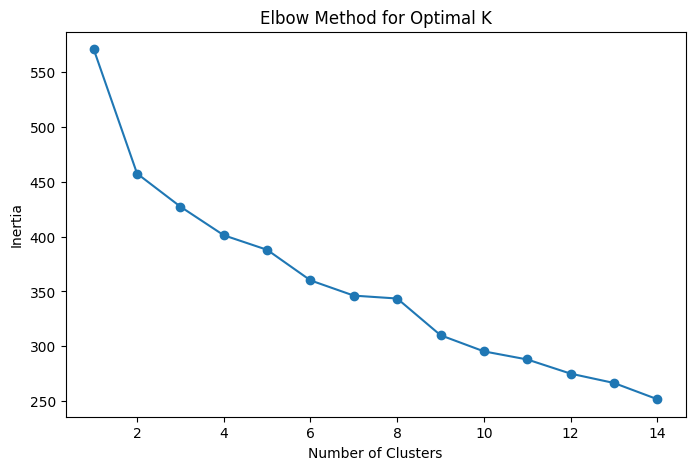

In [582]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
cluster_range = range(1, 15)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_fps_separate_unique) 
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid(False)
plt.show()

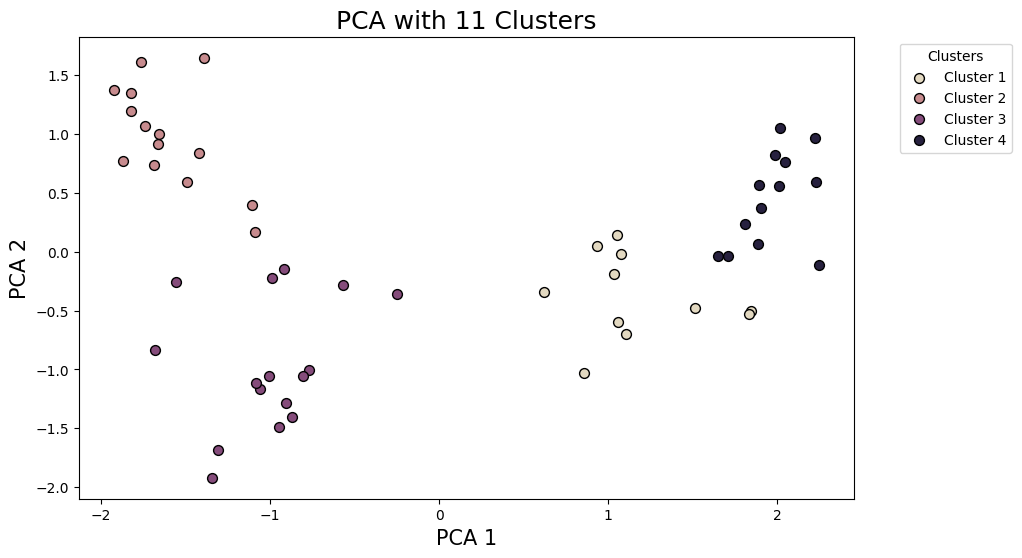

In [589]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_fps_separate_unique)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(pca_df)
pca_df['Cluster'] = clusters

custom_palette = sns.color_palette("ch:s=-.2,r=.6", n_colors=4)


plt.figure(figsize=(10, 6))

for cluster_num in range(4):  
    subset = pca_df[pca_df['Cluster'] == cluster_num]
    plt.scatter(subset['PC1'], subset['PC2'], 
                label=f'Cluster {cluster_num + 1}', 
                color=custom_palette[cluster_num], 
                edgecolor='k', s=50)

plt.xlabel('PCA 1', size=15)
plt.ylabel('PCA 2', size=15)
plt.title('PCA with 4 Clusters', size=18)
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



### By reaction pairs

In [ ]:
df_explainability_0['di_fp'] = [np.random.randint(0, 2, 128) for _ in range(len(df_explainability_0))]
df_explainability_0['tri_fp'] = [np.random.randint(0, 2, 128) for _ in range(len(df_explainability_0))]

df_combined_fp = pd.concat([
    pd.DataFrame(df_explainability_0['di_fp'].tolist(), columns=[f'di_fp_{i}' for i in range(128)]),
    pd.DataFrame(df_explainability_0['tri_fp'].tolist(), columns=[f'tri_fp_{i}' for i in range(128)])
], axis=1)

df_combined_fp['di_smiles'] = df_explainability_0['di_smiles']
df_combined_fp['tri_smiles'] = df_explainability_0['tri_smiles']
df_combined_fp['concatenated_names'] = df_explainability_0['di_name'] + "_" + df_explainability_0['tri_name']

fp_columns = [f'di_fp_{i}' for i in range(128)] + [f'tri_fp_{i}' for i in range(128)]
df_combined_fp_unique = df_combined_fp.drop_duplicates(subset=fp_columns).reset_index(drop=True)

df_combined_fp_unique

In [595]:
df_combined_fp_unique.drop(columns=['di_smiles', 'tri_smiles', 'concatenated_names'], inplace = True)

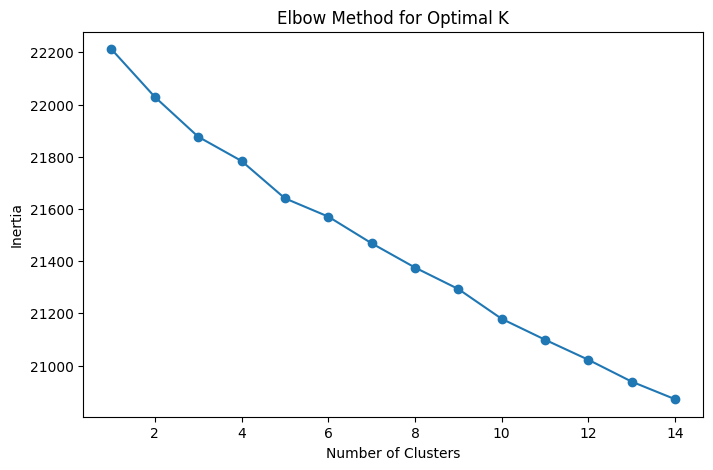

In [596]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
cluster_range = range(1, 15)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_combined_fp_unique) 
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid(False)
plt.show()

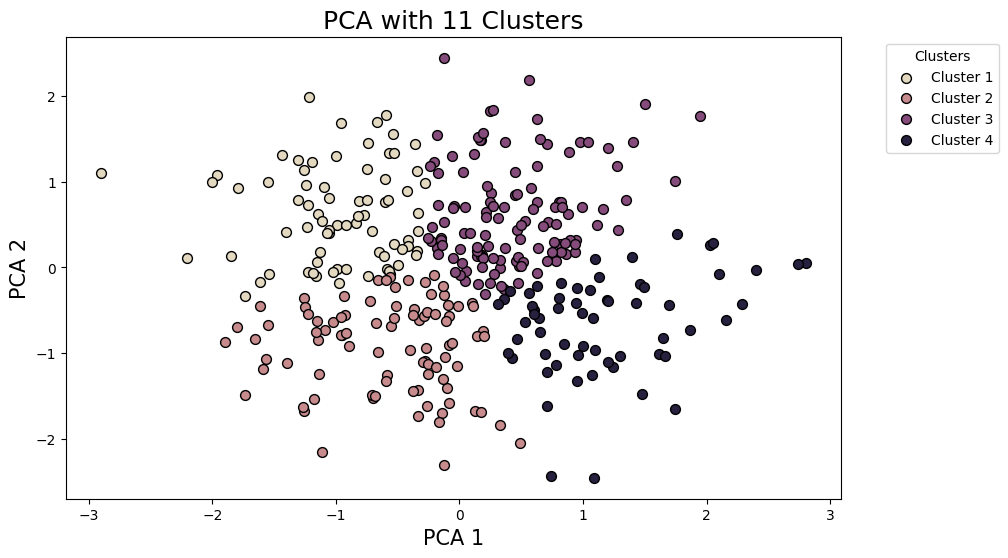

In [597]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_combined_fp_unique)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(pca_df)
pca_df['Cluster'] = clusters

custom_palette = sns.color_palette("ch:s=-.2,r=.6", n_colors=4)


plt.figure(figsize=(10, 6))

for cluster_num in range(4):  
    subset = pca_df[pca_df['Cluster'] == cluster_num]
    plt.scatter(subset['PC1'], subset['PC2'], 
                label=f'Cluster {cluster_num + 1}', 
                color=custom_palette[cluster_num], 
                edgecolor='k', s=50)


plt.xlabel('PCA 1', size=15)
plt.ylabel('PCA 2', size=15)
plt.title('PCA with 11 Clusters', size=18)
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



# Vizualisation of the feature space

### Reduced features

In [ ]:
df_explainability = turbidity_wo_triq_filtered.copy()

In [527]:
df_explainability.columns

Index(['di_name', 'tri_name', 'di_smiles', 'tri_smiles', 'turbidity_binary',
       'di_h_bond_acceptor_count', 'di_h_bond_donor_count', 'di_xlogp',
       'di_tpsa', 'di_arom_group', 'tri_h_bond_acceptor_count',
       'tri_h_bond_donor_count', 'tri_xlogp', 'tri_tpsa', 'tri_arom_group'],
      dtype='object')

In [528]:
df_explainability.drop(columns=['turbidity_binary', 'di_name', 'tri_name', 'di_smiles', 'tri_smiles'], inplace=True)

In [529]:
df_explainability.columns

Index(['di_h_bond_acceptor_count', 'di_h_bond_donor_count', 'di_xlogp',
       'di_tpsa', 'di_arom_group', 'tri_h_bond_acceptor_count',
       'tri_h_bond_donor_count', 'tri_xlogp', 'tri_tpsa', 'tri_arom_group'],
      dtype='object')

### Feature normalizations with min-max

In [ ]:
from sklearn.preprocessing import MinMaxScaler

columns_to_scale = [
    'di_xlogp','di_tpsa', 
    'tri_xlogp', 'tri_tpsa'
]

scaler = MinMaxScaler()

df_explainability[columns_to_scale] = scaler.fit_transform(df_explainability[columns_to_scale])

df_explainability

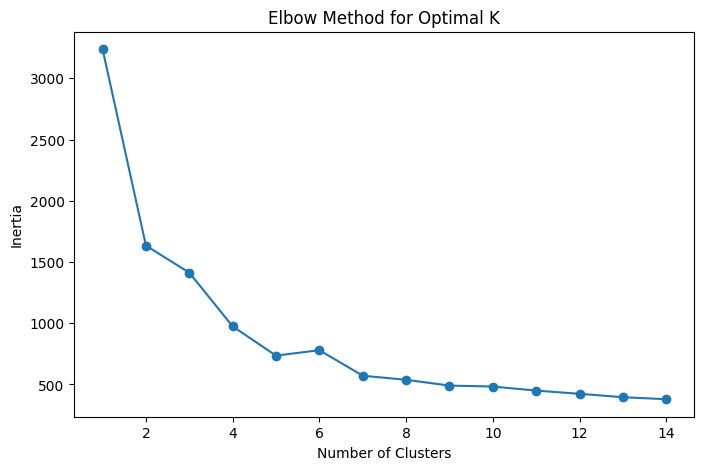

In [531]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
cluster_range = range(1, 15)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_explainability) 
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid(False)
plt.show()


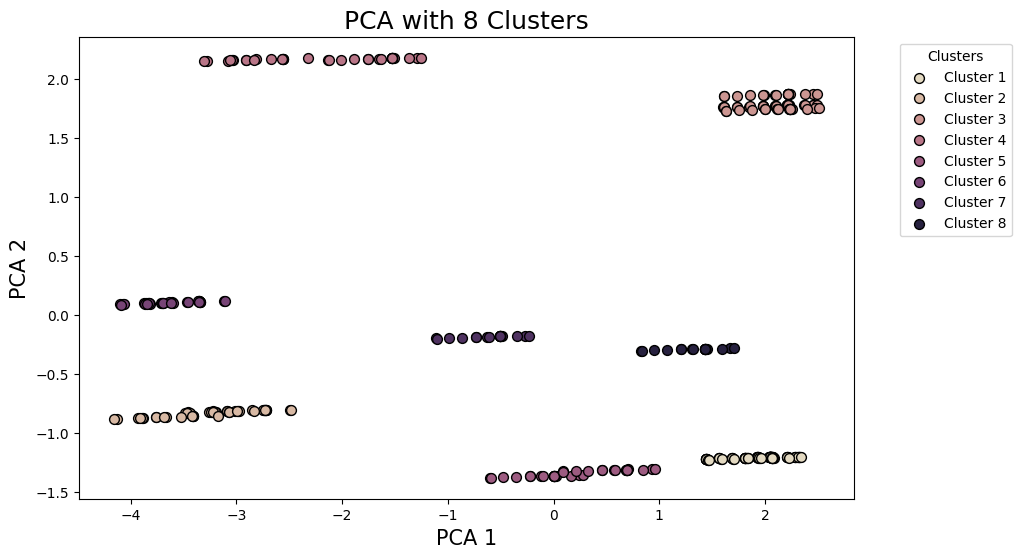

In [545]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_explainability)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

kmeans = KMeans(n_clusters=8, random_state=42)
clusters = kmeans.fit_predict(pca_df)
pca_df['Cluster'] = clusters

custom_palette = sns.color_palette("ch:s=-.2,r=.6", n_colors=8)

plt.figure(figsize=(10, 6))
for cluster_num in range(8):
    subset = pca_df[pca_df['Cluster'] == cluster_num]
    plt.scatter(subset['PC1'], subset['PC2'], 
                label=f'Cluster {cluster_num + 1}', 
                color=custom_palette[cluster_num], 
                edgecolor='k', s=50)

plt.xlabel('PCA 1', size=15)
plt.ylabel('PCA 2', size=15)
plt.title('PCA with 8 Clusters', size=18)

plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### With all features

In [548]:
df_explainability_2 = turbidity_wo_triq_clean.copy()

In [549]:
df_explainability_2.columns

Index(['di_name', 'tri_name', 'di_smiles', 'tri_smiles', 'turbidity_label',
       'turbidity', 'turbidity_binary', 'di_charge', 'di_complexity',
       'di_covalent_unit_count', 'di_defined_atom_stereo_count',
       'di_defined_bond_stereo_count', 'di_exact_mass',
       'di_h_bond_acceptor_count', 'di_h_bond_donor_count',
       'di_heavy_atom_count', 'di_xlogp', 'di_molecular_weight',
       'di_rotatable_bond_count', 'di_tpsa', 'tri_charge', 'tri_complexity',
       'tri_covalent_unit_count', 'tri_defined_atom_stereo_count',
       'tri_defined_bond_stereo_count', 'tri_exact_mass',
       'tri_h_bond_acceptor_count', 'tri_h_bond_donor_count',
       'tri_heavy_atom_count', 'tri_xlogp', 'tri_molecular_weight',
       'tri_rotatable_bond_count', 'tri_tpsa', 'di_arom_group',
       'tri_arom_group'],
      dtype='object')

In [552]:
df_explainability_2.drop(columns=['turbidity_binary', 'turbidity', 'turbidity_label', 'di_name', 'tri_name', 'di_smiles', 'tri_smiles'], inplace=True)

In [553]:
df_explainability_2.columns

Index(['di_charge', 'di_complexity', 'di_covalent_unit_count',
       'di_defined_atom_stereo_count', 'di_defined_bond_stereo_count',
       'di_exact_mass', 'di_h_bond_acceptor_count', 'di_h_bond_donor_count',
       'di_heavy_atom_count', 'di_xlogp', 'di_molecular_weight',
       'di_rotatable_bond_count', 'di_tpsa', 'tri_charge', 'tri_complexity',
       'tri_covalent_unit_count', 'tri_defined_atom_stereo_count',
       'tri_defined_bond_stereo_count', 'tri_exact_mass',
       'tri_h_bond_acceptor_count', 'tri_h_bond_donor_count',
       'tri_heavy_atom_count', 'tri_xlogp', 'tri_molecular_weight',
       'tri_rotatable_bond_count', 'tri_tpsa', 'di_arom_group',
       'tri_arom_group'],
      dtype='object')

### Feature normalizations with min-max

In [ ]:
from sklearn.preprocessing import MinMaxScaler

columns_to_scale_2 = [
    'di_complexity',
    'di_exact_mass',  
    'di_xlogp', 'di_molecular_weight',
    'di_tpsa', 'tri_complexity',
    'tri_exact_mass',
    'tri_xlogp', 'tri_molecular_weight',
    'tri_tpsa', 
    ]

scaler = MinMaxScaler()

df_explainability_2[columns_to_scale_2] = scaler.fit_transform(df_explainability_2[columns_to_scale_2])

df_explainability_2

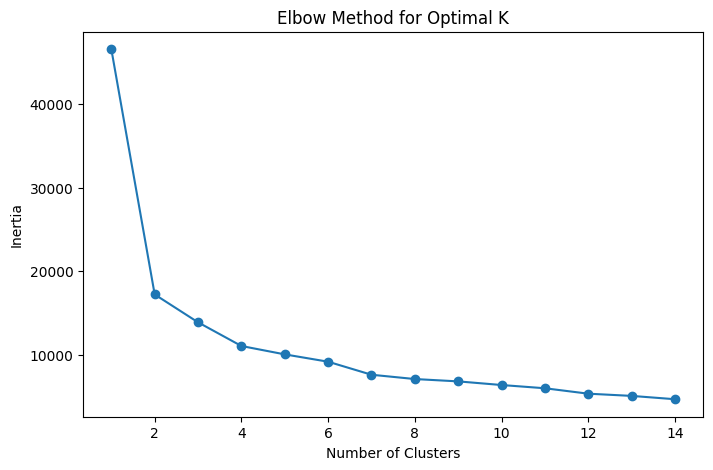

In [555]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
cluster_range = range(1, 15)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_explainability_2) 
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid(False)
plt.show()


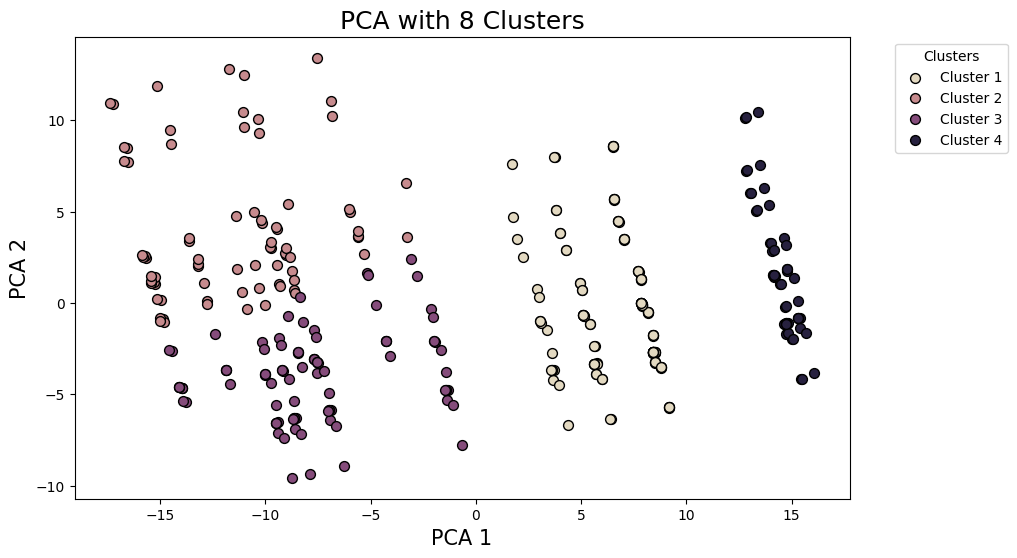

In [562]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_explainability_2)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(pca_df)
pca_df['Cluster'] = clusters

custom_palette = sns.color_palette("ch:s=-.2,r=.6", n_colors=4)

plt.figure(figsize=(10, 6))
for cluster_num in range(4):
    subset = pca_df[pca_df['Cluster'] == cluster_num]
    plt.scatter(subset['PC1'], subset['PC2'], 
                label=f'Cluster {cluster_num + 1}', 
                color=custom_palette[cluster_num], 
                edgecolor='k', s=50)

plt.xlabel('PCA 1', size=15)
plt.ylabel('PCA 2', size=15)
plt.title('PCA with 8 Clusters', size=18)

plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# Selected features and the fingerprints

In [617]:
df_explainability_final = turbidity_wo_triq_filtered.copy()

In [618]:
df_explainability_final.columns

Index(['di_name', 'tri_name', 'di_smiles', 'tri_smiles', 'turbidity_binary',
       'di_h_bond_acceptor_count', 'di_h_bond_donor_count', 'di_xlogp',
       'di_tpsa', 'di_arom_group', 'tri_h_bond_acceptor_count',
       'tri_h_bond_donor_count', 'tri_xlogp', 'tri_tpsa', 'tri_arom_group'],
      dtype='object')

In [619]:
def smiles_to_fingerprint(smiles, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=n_bits)
        return list(fp)
    else:

        return [0] * n_bits

In [ ]:
di_fps = df_explainability_final['di_smiles'].apply(lambda x: smiles_to_fingerprint(x))
di_fps_df = pd.DataFrame(di_fps.tolist(), columns=[f'di_fps_{i+1}' for i in range(2048)])

tri_fps = df_explainability_final['tri_smiles'].apply(lambda x: smiles_to_fingerprint(x))
tri_fps_df = pd.DataFrame(tri_fps.tolist(), columns=[f'tri_fps_{i+1}' for i in range(2048)])

df_final = pd.concat([df_explainability_final, di_fps_df, tri_fps_df], axis=1)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

columns_to_scale = [
    'di_xlogp','di_tpsa', 
    'tri_xlogp', 'tri_tpsa'
]

scaler = MinMaxScaler()

df_final[columns_to_scale] = scaler.fit_transform(df_final[columns_to_scale])

df_final

In [633]:
df_final.columns

Index(['di_name', 'tri_name', 'di_smiles', 'tri_smiles', 'turbidity_binary',
       'di_h_bond_acceptor_count', 'di_h_bond_donor_count', 'di_xlogp',
       'di_tpsa', 'di_arom_group',
       ...
       'tri_fps_2039', 'tri_fps_2040', 'tri_fps_2041', 'tri_fps_2042',
       'tri_fps_2043', 'tri_fps_2044', 'tri_fps_2045', 'tri_fps_2046',
       'tri_fps_2047', 'tri_fps_2048'],
      dtype='object', length=4111)

In [ ]:
df_final.drop(columns=['di_smiles', 'di_name', 'tri_smiles', 'tri_name'], inplace = True)

In [639]:
df_final.columns

Index(['turbidity_binary', 'di_h_bond_acceptor_count', 'di_h_bond_donor_count',
       'di_xlogp', 'di_tpsa', 'di_arom_group', 'tri_h_bond_acceptor_count',
       'tri_h_bond_donor_count', 'tri_xlogp', 'tri_tpsa',
       ...
       'tri_fps_2039', 'tri_fps_2040', 'tri_fps_2041', 'tri_fps_2042',
       'tri_fps_2043', 'tri_fps_2044', 'tri_fps_2045', 'tri_fps_2046',
       'tri_fps_2047', 'tri_fps_2048'],
      dtype='object', length=4107)

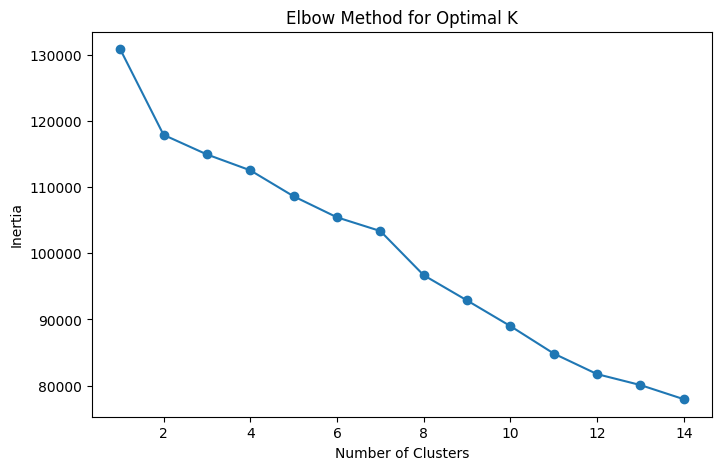

In [642]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

X = df_final.select_dtypes(include=[float, int])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertia = []
cluster_range = range(1, 15)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)  
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid(False)
plt.show()


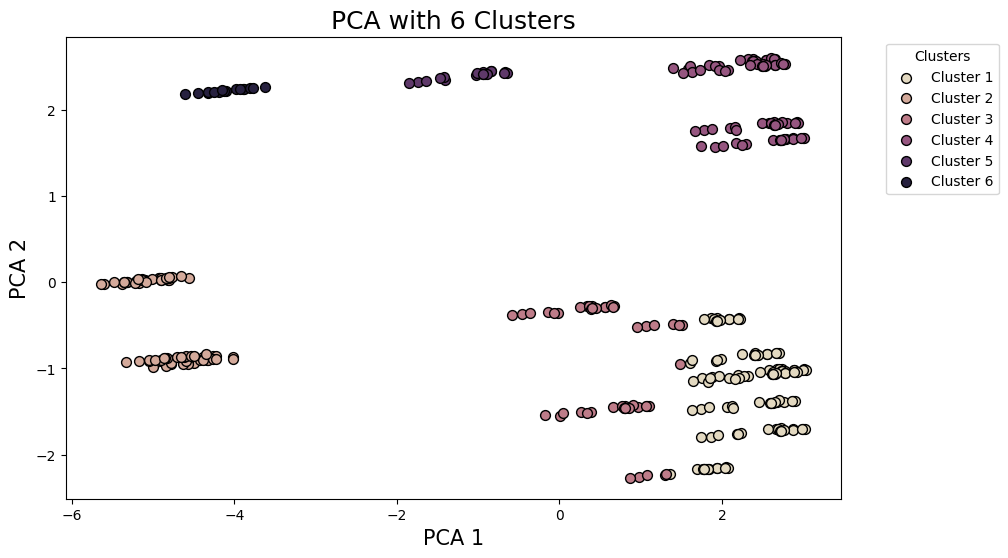

In [647]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

custom_palette = sns.color_palette("ch:s=-.2,r=.6", n_colors=6)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_final)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(pca_df)
pca_df['Cluster'] = clusters

plt.figure(figsize=(10, 6))
for cluster_num in range(6):
    subset = pca_df[pca_df['Cluster'] == cluster_num]
    plt.scatter(subset['PC1'], subset['PC2'], 
                label=f'Cluster {cluster_num + 1}', 
                color=custom_palette[cluster_num], 
                edgecolor='k', s=50)

plt.xlabel('PCA 1', size=15)
plt.ylabel('PCA 2', size=15)
plt.title('PCA with 6 Clusters', size=18)

plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# Getting the clusters examples out from selected features + fps

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

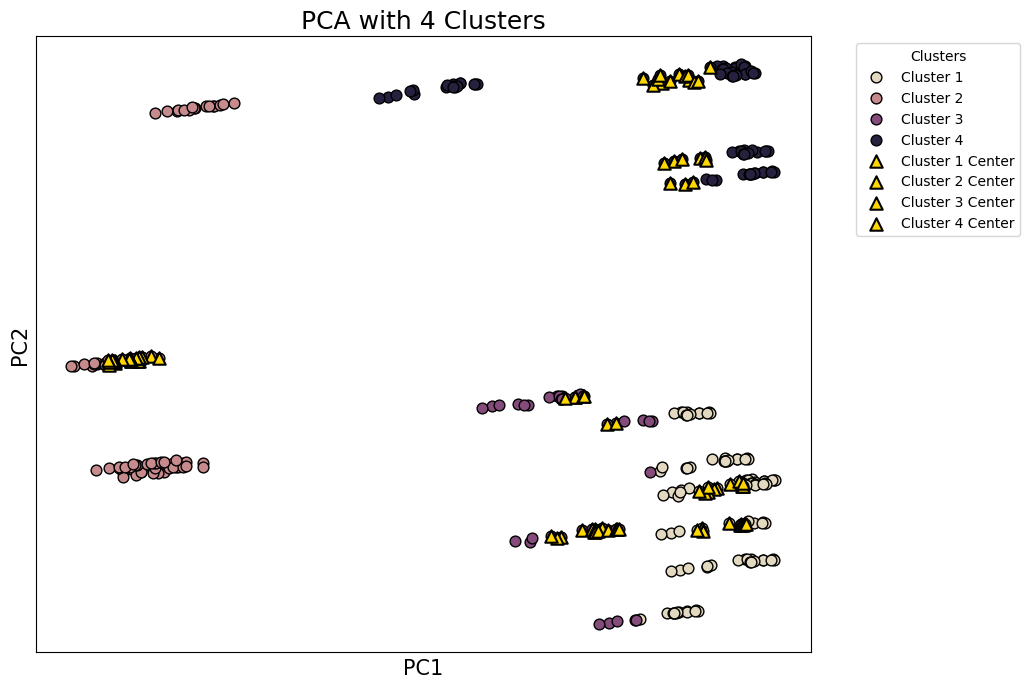

In [656]:
n_clusters = 4  

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_final.select_dtypes(include=[float, int]))
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(pca_df)
pca_df['Cluster'] = clusters

clustered_data = {f'Cluster_{i}': pca_df[pca_df['Cluster'] == i] for i in range(n_clusters)}

centered_data = {}
for cluster_id, cluster_df in clustered_data.items():
    cluster_num = int(cluster_id.split('_')[-1])
    if cluster_num < len(kmeans.cluster_centers_):  
        centroid = kmeans.cluster_centers_[cluster_num]
        
        _, distances = pairwise_distances_argmin_min(cluster_df[['PC1', 'PC2']], [centroid])
        
        closest_indices = distances.argsort()[:22]
        centered_data[cluster_id] = cluster_df.iloc[closest_indices]

plt.figure(figsize=(10, 8))

palette = sns.color_palette("ch:s=-.2,r=.6", n_colors=len(clustered_data))

for idx, (cluster_id, cluster_df) in enumerate(clustered_data.items()):
    plt.scatter(cluster_df['PC1'], cluster_df['PC2'], 
                label=f'Cluster {idx + 1}',  
                s=60, 
                color=palette[idx], 
                edgecolor='black') 

for idx, (cluster_id, center_df) in enumerate(centered_data.items()):
    plt.scatter(center_df['PC1'], center_df['PC2'], 
                edgecolor='black', 
                color='gold', 
                s=80, 
                marker='^', 
                label=f'Cluster {idx + 1} Center', 
                linewidths=1.5)

plt.xlabel('PC1', size=15)
plt.ylabel('PC2', size=15)
plt.title(f'PCA with {n_clusters} Clusters', size=18)

plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(False)
plt.xticks([])
plt.yticks([])

plt.show()


In [657]:
print("Number of clusters:", len(kmeans.cluster_centers_))
print("Cluster centers shape:", kmeans.cluster_centers_.shape)


Number of clusters: 4
Cluster centers shape: (4, 2)


In [658]:
for cluster_id, center_df in centered_data.items():
    print(f"{cluster_id} - Number of centered elements: {len(center_df)}")
    print(center_df)  
    print("\n")

Cluster_0 - Number of centered elements: 22
          PC1       PC2  Cluster
124  2.315033 -1.083039        0
336  2.453081 -1.382945        0
128  2.269874 -1.090549        0
214  2.204042 -1.113434        0
218  2.158883 -1.120944        0
116  2.196729 -1.074608        0
210  2.471943 -1.045851        0
340  2.120505 -1.429835        0
344  2.140021 -1.458038        0
206  2.085738 -1.105003        0
343  2.597014 -1.402113        0
331  2.607130 -1.397551        0
347  2.609586 -1.400425        0
337  2.632465 -1.398407        0
217  2.615876 -1.065019        0
120  2.582934 -1.015456        0
332  2.066876 -1.442097        0
342  2.650623 -1.393395        0
205  2.625991 -1.060457        0
221  2.628448 -1.063331        0
204  2.626629 -1.036557        0
330  2.672442 -1.394344        0


Cluster_1 - Number of centered elements: 22
         PC1       PC2  Cluster
65 -4.660773  0.070093        1
43 -4.765334  0.058371        1
35 -4.802303  0.027833        1
32 -4.817998  0.023992 

In [674]:
cluster_dfs = {}

for cluster_id, center_df in centered_data.items():
    centered_indexes = center_df.index
    
    cluster_df = prompts_df.loc[centered_indexes]
    
    cluster_dfs[cluster_id] = cluster_df

print(cluster_dfs.keys())


print("Sample of Cluster 1 DataFrame:")
print(cluster_dfs['Cluster_0'].head())  


dict_keys(['Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3'])
Sample of Cluster 1 DataFrame:
                                                Prompt  Answer
124  Is the mixture between ditopic NCc1ccc(CN)cc1 ...       1
336  Is the mixture between ditopic N[C@H]1CCC[C@H]...       0
128  Is the mixture between ditopic NCC1=CC(CN)=CC=...       1
214  Is the mixture between ditopic NCc1ccc(CN)cc1 ...       1
218  Is the mixture between ditopic NCC1=CC(CN)=CC=...       1


In [675]:
output_directory = "/Users/davidsegura/git/Leveraging_LLMs_causality/cage_SAD_llm/data/data_explainability/"  

for cluster_id, cluster_df in cluster_dfs.items():

    file_name = f"{output_directory}{cluster_id}.csv"
    
    cluster_df.to_csv(file_name, index=False)  

    print(f"Saved {cluster_id} to {file_name}")


Saved Cluster_0 to /Users/davidsegura/git/Leveraging_LLMs_causality/cage_SAD_llm/data/data_explainability/Cluster_0.csv
Saved Cluster_1 to /Users/davidsegura/git/Leveraging_LLMs_causality/cage_SAD_llm/data/data_explainability/Cluster_1.csv
Saved Cluster_2 to /Users/davidsegura/git/Leveraging_LLMs_causality/cage_SAD_llm/data/data_explainability/Cluster_2.csv
Saved Cluster_3 to /Users/davidsegura/git/Leveraging_LLMs_causality/cage_SAD_llm/data/data_explainability/Cluster_3.csv


# News ways to prompt

In [668]:
data_prompt_new_1 = pd.read_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/cage_SAD_llm/data/reduced_dataset_turbidity.csv')

In [670]:
import pandas as pd

prompt_data = []

for index, row in data_prompt_new_1.iterrows():

    prompt = (
        f"Is the mixture between ditopic {row['di_smiles']} and tritopic {row['tri_smiles']} turbid or dissolved? "
        f"Knowing the following properties in ditopic and tritopic molecules respectively: "
        f"The number of aromatic groups: {row['di_arom_group']}, {row['tri_arom_group']}. "
        f"The number of hydrogen bond acceptors: {row['di_h_bond_acceptor_count']}, {row['tri_h_bond_acceptor_count']}. "
        f"The number of hydrogen bond donors: {row['di_h_bond_donor_count']}, {row['tri_h_bond_donor_count']}. "
        f"The logP (octanol/water partition coefficient): {row['di_xlogp']}, {row['tri_xlogp']}. "
        f"The TPSA (topological polar surface area): {row['di_tpsa']}, {row['tri_tpsa']}."

    )
    
    prompt_data.append({"Prompt": prompt, "Answer": row["turbidity_binary"]})

prompts_df = pd.DataFrame(prompt_data)


In [671]:
data_prompt_new_2 = pd.read_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/cage_SAD_llm/data/all_dataset_turbidity.csv')

In [672]:
import pandas as pd

prompt_data_2 = []

for index, row in data_prompt_new_2.iterrows():

    prompt_2 = (
        f"Is the mixture between ditopic {row['di_smiles']} and tritopic {row['tri_smiles']} turbid or dissolved? "
        f"Knowing the following properties in ditopic and tritopic molecules respectively: "
        f"The number of aromatic groups: {row['di_arom_group']}, {row['tri_arom_group']}. "
        f"The number of hydrogen bond acceptors: {row['di_h_bond_acceptor_count']}, {row['tri_h_bond_acceptor_count']}. "
        f"The number of hydrogen bond donors: {row['di_h_bond_donor_count']}, {row['tri_h_bond_donor_count']}. "
        f"The logP (octanol/water partition coefficient): {row['di_xlogp']}, {row['tri_xlogp']}. "
        f"The TPSA (topological polar surface area): {row['di_tpsa']}, {row['tri_tpsa']}."

    )
    
    prompt_data_2.append({"Prompt": prompt, "Answer": row["turbidity_binary"]})

prompts_df_2 = pd.DataFrame(prompt_data_2)


In [673]:
prompts_df.to_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/cage_SAD_llm/data/reduced_shorter_prompt_data_turbidity.csv')
prompts_df_2.to_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/cage_SAD_llm/data/all_shorter_prompt_data_turbidity.csv')


In [611]:
print(prompts_df.shape, prompts_df_2.shape)

(348, 2) (348, 2)
